In [1]:
import torch
import torch.nn as nn
import math

import matplotlib.pyplot as plt

from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from utils.weakener import Weakener
from models.general_model import MLP
from utils.losses import PartialLoss,LBLoss,EMLoss,OSLCELoss,OSLBrierLoss,CELoss
from utils.trainig_testing import train_model,evaluate_model,train_and_evaluate,ES_train_and_evaluate

In [2]:
dataset = 'mnist'
weakening = 'random' #for possible ['random','feature']

Data = Torch_Dataset(dataset, batch_size=256)
Weak = Weakener(Data.num_classes)
Weak.generate_M('pll',pll_p=0.5)

In [3]:
train_X,train_y,test_X,test_y =  Data.get_data()
print(train_X.shape)
Weak.generate_weak(train_y)

torch.Size([60000, 784])


(tensor([ 679,  739,  793,  ..., 1004,  162,   20], dtype=torch.int32),
 tensor([[1., 0., 1.,  ..., 0., 1., 0.],
         [1., 0., 1.,  ..., 1., 1., 0.],
         [1., 1., 0.,  ..., 1., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 1.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]], dtype=torch.float64))

In [4]:
mlp_feature = MLP(Data.num_features, [Data.num_features, Data.num_features, Data.num_features], Data.num_classes, dropout_p = 0.0, bn = False, seed = 1,
                  layer_init = lambda x: nn.init.kaiming_uniform_(x, a=math.sqrt(5)))

In [5]:
print(mlp_feature.state_dict().keys())

valen_weights = torch.load('results/mnist_random')
print(valen_weights.keys())

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.1.weight', 'layers.1.bias', 'layers.2.weight', 'layers.2.bias', 'layers.3.weight', 'layers.3.bias'])
odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [6]:
# We see that the mlp parameters and the weights taken from valen are initially different
w = 'layers.0.weight'
w1 = w.split('.')
name = 'fc'+str(int(w1[1])+1)+'.'+w1[2]
print(name)
print(valen_weights[name])
print(w)
print(mlp_feature.state_dict()[w])

fc1.weight
tensor([[ 0.0172, -0.0161, -0.0075,  ...,  0.0059, -0.0047,  0.0017],
        [-0.0267, -0.0219, -0.0302,  ..., -0.0029,  0.0012, -0.0163],
        [ 0.0275, -0.0093, -0.0333,  ..., -0.0138,  0.0055, -0.0328],
        ...,
        [-0.0015, -0.0159, -0.0231,  ..., -0.0109,  0.0195, -0.0093],
        [ 0.0065,  0.0274, -0.0327,  ...,  0.0053,  0.0243,  0.0175],
        [-0.0229, -0.0293,  0.0004,  ..., -0.0110,  0.0073, -0.0074]])
layers.0.weight
tensor([[ 0.0035,  0.0052,  0.0204,  ...,  0.0049,  0.0135, -0.0151],
        [ 0.0047, -0.0078,  0.0343,  ..., -0.0142, -0.0098,  0.0058],
        [-0.0316, -0.0248, -0.0252,  ..., -0.0233, -0.0335,  0.0179],
        ...,
        [-0.0104,  0.0225, -0.0054,  ..., -0.0116, -0.0109, -0.0114],
        [-0.0007, -0.0176, -0.0028,  ..., -0.0159,  0.0323,  0.0165],
        [ 0.0004, -0.0072,  0.0057,  ...,  0.0117, -0.0161, -0.0064]])


In [7]:
def weight_allocation(net,weights):
    for name, param in net.named_parameters():
        w = name.split('.')
        w_name = 'fc'+str(int(w[1])+1)+'.'+w[2]
        param.data = weights[w_name]
    return net
mlp_feature = weight_allocation(mlp_feature,valen_weights)

In [8]:
w = 'layers.0.weight'
w1 = w.split('.')
name = 'fc'+str(int(w1[1])+1)+'.'+w1[2]
print(name)
print(valen_weights[name])
print(w)
print(mlp_feature.state_dict()[w])

fc1.weight
tensor([[ 0.0172, -0.0161, -0.0075,  ...,  0.0059, -0.0047,  0.0017],
        [-0.0267, -0.0219, -0.0302,  ..., -0.0029,  0.0012, -0.0163],
        [ 0.0275, -0.0093, -0.0333,  ..., -0.0138,  0.0055, -0.0328],
        ...,
        [-0.0015, -0.0159, -0.0231,  ..., -0.0109,  0.0195, -0.0093],
        [ 0.0065,  0.0274, -0.0327,  ...,  0.0053,  0.0243,  0.0175],
        [-0.0229, -0.0293,  0.0004,  ..., -0.0110,  0.0073, -0.0074]])
layers.0.weight
tensor([[ 0.0172, -0.0161, -0.0075,  ...,  0.0059, -0.0047,  0.0017],
        [-0.0267, -0.0219, -0.0302,  ..., -0.0029,  0.0012, -0.0163],
        [ 0.0275, -0.0093, -0.0333,  ..., -0.0138,  0.0055, -0.0328],
        ...,
        [-0.0015, -0.0159, -0.0231,  ..., -0.0109,  0.0195, -0.0093],
        [ 0.0065,  0.0274, -0.0327,  ...,  0.0053,  0.0243,  0.0175],
        [-0.0229, -0.0293,  0.0004,  ..., -0.0110,  0.0073, -0.0074]])


In [9]:
z, w = Weak.generate_weak(train_y)

In [10]:
Data.include_weak(Weak.w)

In [11]:
trainloader, testloader = Data.get_dataloader()

In [12]:
evaluate_model(mlp_feature,testloader)

Evaluation Accuracy: 0.9358


tensor(0.9358, dtype=torch.float64)

In [13]:

optimizer = torch.optim.Adam(mlp_feature.parameters(), lr=1e-2)
#optimizer = torch.optim.SGD(mlp_feature.parameters(), lr=1e-2, weight_decay=1e-4,momentum=0.9,nesterov=True )
loss_fn = OSLCELoss()

mlp_feature,results = ES_train_and_evaluate(mlp_feature,trainloader,testloader,optimizer,loss_fn,num_epochs=100,patience=100)

Epoch 1/100: Train Loss: 15.2244, Train Acc: 0.4015, Test Acc: 0.5338
Epoch 2/100: Train Loss: 0.6806, Train Acc: 0.5965, Test Acc: 0.6045
Epoch 3/100: Train Loss: 0.6693, Train Acc: 0.6059, Test Acc: 0.6323
Epoch 4/100: Train Loss: 0.6060, Train Acc: 0.6398, Test Acc: 0.6174
Epoch 5/100: Train Loss: 0.5656, Train Acc: 0.6666, Test Acc: 0.7005
Epoch 6/100: Train Loss: 0.5044, Train Acc: 0.7035, Test Acc: 0.7074
Epoch 7/100: Train Loss: 0.4969, Train Acc: 0.7118, Test Acc: 0.6928
Epoch 8/100: Train Loss: 0.5386, Train Acc: 0.6923, Test Acc: 0.7211
Epoch 9/100: Train Loss: 0.4786, Train Acc: 0.7147, Test Acc: 0.7166
Epoch 10/100: Train Loss: 0.4509, Train Acc: 0.7112, Test Acc: 0.7266
Epoch 11/100: Train Loss: 0.4633, Train Acc: 0.7084, Test Acc: 0.7168
Epoch 12/100: Train Loss: 0.4717, Train Acc: 0.7043, Test Acc: 0.7015
Epoch 13/100: Train Loss: 0.4580, Train Acc: 0.7067, Test Acc: 0.6720
Epoch 14/100: Train Loss: 0.6586, Train Acc: 0.6301, Test Acc: 0.6224
Epoch 15/100: Train Loss: 0.

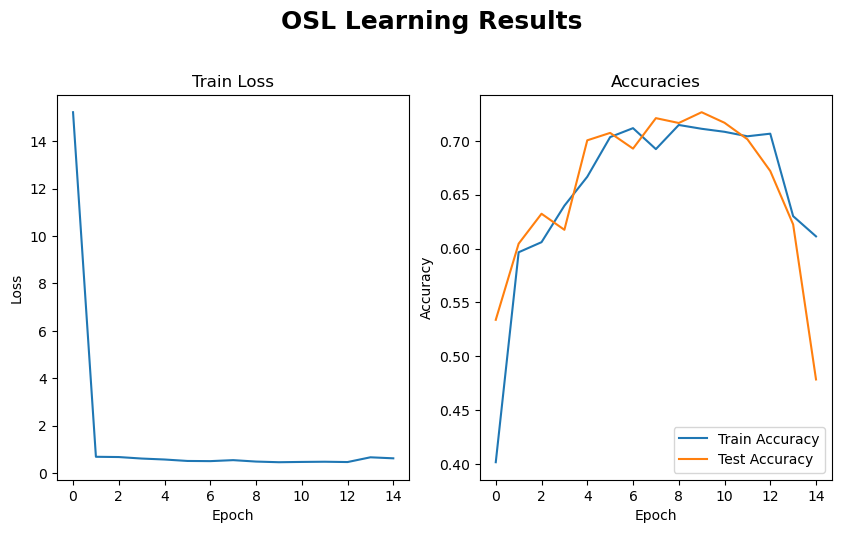

In [14]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot (Train Loss)
ax1.plot(results['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')

# Plot the second subplot (Accuracies)
ax2.plot(results['train_acc'], label='Train Accuracy')
ax2.plot(results['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
ax2.legend()

fig.suptitle('OSL Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()